In [1]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from handyspark import *
from matplotlib import pyplot as plt

findspark.init()
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

%matplotlib inline

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
sdf = spark.read.csv('train.csv', header=True, inferSchema=True)

In [4]:
hdf = sdf.toHandy()

In [5]:
hdf.isnull(ratio=True)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
Name: missing(ratio), dtype: float64

In [8]:
hdf.cols[:][:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C


In [7]:
hdf.safety_off().cols[:][:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C


In [9]:
hdf.stratify(['Pclass']).cols['Cabin'].nunique()

Pclass  0    
1       Cabin    133
2       Cabin      7
3       Cabin      7
Name: nunique, dtype: int64

In [10]:
col_mr = hdf.pandas['Name'].str.find(sub='Mr.')
col_mr

Column<b'udf(Name) AS `<lambda>(Name,)`'>

In [11]:
hdf.assign(pos_mr=col_mr).show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|pos_mr|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|     8|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|    -1|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|    -1|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|    -1|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|     7|
+-----------+--------+--

In [12]:
hdf.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [13]:
hdf.cols[hdf.cols.numerical].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.029340,-0.035349,0.036847,-0.082398,-0.011617,0.009592
Survived,0.029340,1.000000,-0.359653,-0.077221,-0.017358,0.093317,0.268189
Pclass,-0.035349,-0.359653,1.000000,-0.369226,0.067247,0.025683,-0.554182
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.082398,-0.017358,0.067247,-0.308247,1.000000,0.383820,0.138329
Parch,-0.011617,0.093317,0.025683,-0.189119,0.383820,1.000000,0.205119
Fare,0.009592,0.268189,-0.554182,0.096067,0.138329,0.205119,1.000000


In [14]:
hdf.cols[:].stddev()

PassengerId     257.354
Survived       0.486592
Pclass         0.836071
Age             14.5265
SibSp           1.10274
Parch          0.806057
Fare            49.6934
Name: stddev, dtype: object

In [15]:
hdf.cols['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
hdf.stratify(['Pclass']).cols['Embarked'].value_counts()

Pclass  Embarked
1       C            85
        Q             2
        S           127
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
Name: value_counts, dtype: int64

In [17]:
hdf.stratify(['Pclass', Bucket('Age', 3)]).cols['Embarked'].value_counts()

Pclass  Age                                Embarked
1       Age >= 0.4200 and Age < 26.9467    C            21
                                           S            23
        Age >= 26.9467 and Age < 53.4733   C            40
                                           Q             2
                                           S            68
        Age >= 53.4733 and Age <= 80.0000  C            13
                                           S            17
2       Age >= 0.4200 and Age < 26.9467    C             8
                                           S            59
        Age >= 26.9467 and Age < 53.4733   C             7
                                           Q             1
                                           S            86
        Age >= 53.4733 and Age <= 80.0000  Q             1
                                           S            11
3       Age >= 0.4200 and Age < 26.9467    C            28
                                           Q            14
    

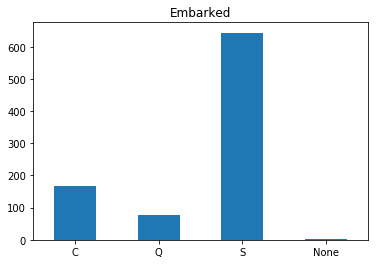

In [18]:
hdf.cols['Embarked'].hist()

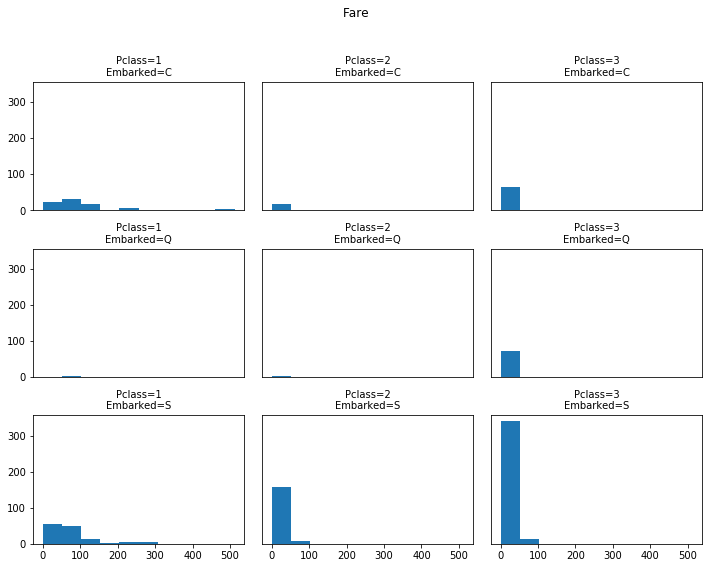

In [25]:
fig = hdf.stratify(['Pclass', 'Embarked']).cols['Fare'].hist(figsize=(10, 8))

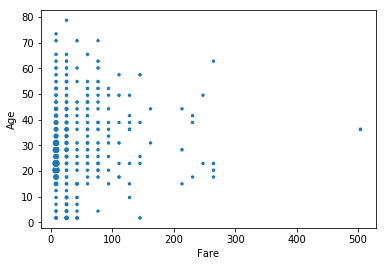

In [20]:
hdf.cols[['Fare', 'Age']].scatterplot()

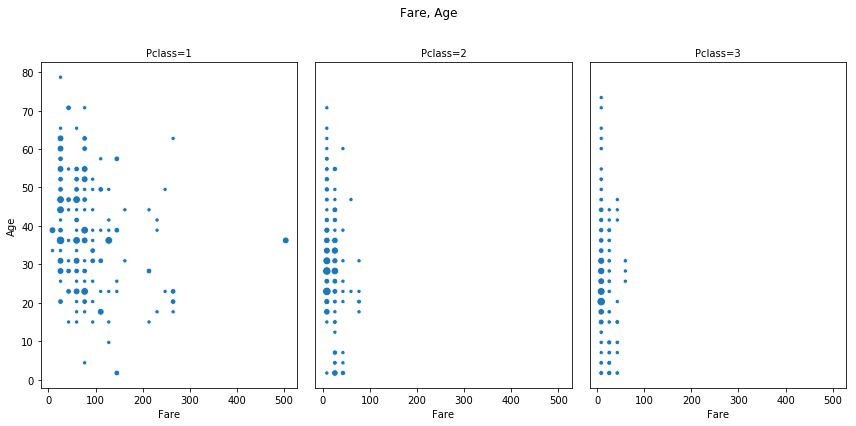

In [22]:
fig = hdf.stratify(['Pclass']).cols[['Fare', 'Age']].scatterplot(figsize=(12, 6))

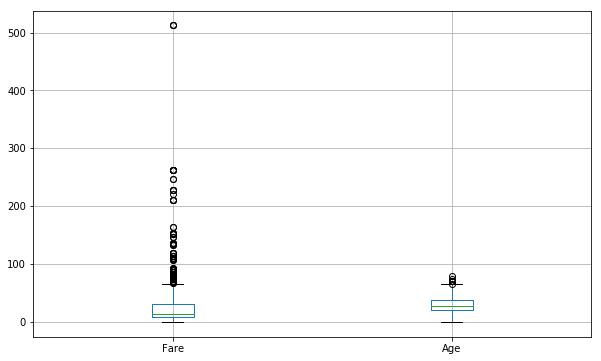

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hdf.cols[['Fare', 'Age']].boxplot(ax=ax)

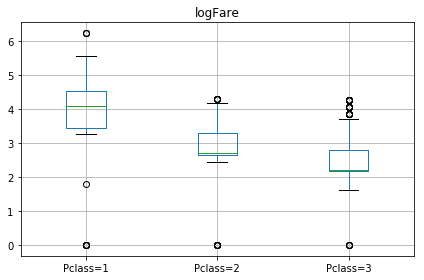

In [22]:
import numpy as np
fig = hdf.assign(logFare=lambda Fare: np.log(Fare + 1)).stratify(['Pclass']).cols['logFare'].boxplot()